In [1]:
#import the pRNN class
#from prnn.utils.predictiveNetReformat import PredictiveNet
from prnn.utils.predictiveNet import PredictiveNet

from prnn.utils.env import make_env
from prnn.utils.agent import RandomActionAgent


import matplotlib.pyplot as plt
import numpy as np

wandb not installed, will not log to wandb


In [2]:
#Make a gridworld environment
env_package = 'gym-minigrid' 
env_key = 'MiniGrid-LRoom-18x18-v0'
act_enc = 'SpeedHD' #actions will be encoded as speed and one hot-encoded head direction

env = make_env(env_key=env_key, package=env_package, act_enc=act_enc)

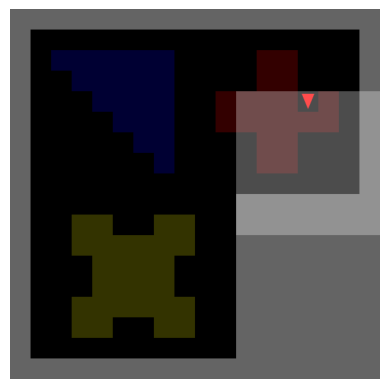

In [3]:
#Let's take a look at the environment
env.reset()
render = env.render()

plt.figure()
plt.subplot(1,1,1)
plt.imshow(render)
plt.axis('off')
plt.show()

In [4]:
#Make a pRNN
num_neurons = 500
pRNNtype = 'thcycRNN_5win_full' #This will train a 5-step masked pRNN. 
                        #For a rollout network use 'thcycRNN_5win_full'

predictiveNet = PredictiveNet(env, hidden_size=num_neurons, pRNNtype=pRNNtype)

In [5]:
#specify an action policy (agent)
action_probability = np.array([0.15,0.15,0.6,0.1,0,0,0])
agent = RandomActionAgent(env.action_space, action_probability)


In [6]:
#run a sample trajectory (note: predictions will be garbage, agent is untrained)
#predictiveNet.plotSampleTrajectory(env,agent)
#plt.show()


In [7]:
#Run one training epoch of 500 trials, each 500 steps long
sequence_duration = 6 # (500) #minimum 6
num_trials = 6 #0 (50) #minimum 6 (why is this the case...)

predictiveNet.trainingEpoch(env, agent,
                            sequence_duration=sequence_duration,
                            num_trials=num_trials)

Training pRNN on cpu...
loss: 0.042, sparsity: 2.2e+02, meanrate: 0.39 [    0\    6]
loss: 0.034, sparsity: 2.2e+02, meanrate: 0.39 [    3\    6]
loss: 0.022, sparsity: 2.3e+02, meanrate: 0.39 [    5\    6]
Epoch Complete. Back to the cpu


In [8]:
#run a sample trajectory. did the predictions get better?
#predictiveNet.plotSampleTrajectory(env,agent)
#plt.show()


In [9]:
obs, act, state, render = predictiveNet.collectObservationSequence(env,agent,10,discretize=True)
obs_pred, obs_next, h  = predictiveNet.predict(obs,act, fullRNNstate=False)

In [10]:
print(h.shape)

torch.Size([6, 5, 500])


In [ ]:
#Let's take a look at the spatial position decoding and tuning curves 
place_fields, SI, decoder = predictiveNet.calculateSpatialRepresentation(env,agent,
                                                trainDecoder=True, saveTrainingData=True)

predictiveNet.calculateDecodingPerformance(env,agent,decoder)
predictiveNet.plotTuningCurvePanel()


In [ ]:
#Looks like we'll need to train some more. This will take a while... 
#Often we like to precompute a dataset of random trajectories to speed things up
#  - check out dataloader_example.ipynb for how to do this

#the script trainNet.py can be used to train a network for many epochs and save the results
#this can be called in a bash scipt to submit a job using e.g. 
# trainNet.py --savefolder='examplenet/' --lr=2e-3 --numepochs=50 --batchsize=16 --pRNNtype='thRNN_5win' --actenc='SpeedHD'
#You'll want to modify it or make your own, to fit the needs of your own project
#An example of how to call it, and submit on a GPU cluster is in trainNet_slurm.sh 